# Predicting Product Category Profit for Tableau's 'Sample-Superstore'
<p align="center">
<img src="https://github.com/Lwhieldon/IntroToDataAnalysis/blob/master/Images/SampleSuperstore.png?raw=true" width="300" height="300" />
</p>

## Overview & Business Value
To stay on top of supply and demand, businesses are looking to find ways to better understand their future profits and success in their respective industry.

For this assignment, I will pretend to be a data scientist for Tableau's 'Sample-Superstore', in which I use machine learning techniques to predict future profit by product category for 'Sample-Superstore' by selecting a regression model that best fits to the data.

To provide a little bit more background about 'Sample-Superstore', it is a US-based company that sells office supplies; it relies heavily on its regional managers to stay on top of tracking product groups to ensure total company profits. The regional managers have asked me, as their data scientist, to help them understand company profit by product category in future years based on the past 4 years on data (no 2020 data is include since the year hasn't finished). They provided this data in excel format, which includes all products sold, categories of products, product names, customer information (location and name) and their quantities & profits respectively.

The model that I create will be key critical in end of year executive meetings, where the regional managers will present predicted future profit for products for the upcoming year. The business will use the output of this model to compare current year's data (when the data becomes available) to see if what is predicted aligns with current business trends or if they need to reassess what products they make to drive profits up. 

How is 'Super-store' predicting future profits today? In essence, by guessing. Executives want the ability to predict future profits rather than by guessing alone, and so the executives believe the model will be useful to accurately assess future profits by product category for the company. 

To help answer Sample-Superstore's business problem, I will be applying supervised learning, since we are given labeled training examples. It is a multiple regression task since our model will use multiple features to make the total company profit prediction. Additionally, this is a univariate model since we are predicting product category profit only.







In [1]:
import pandas as pd
import requests
import io
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

os.chdir(r'C:\Users\lwhieldon\OneDrive - SC&H Group\Administrative\School Materials\DATA 602 - Into to Data Analysis and ML\IntroToDataAnalysis\Images')

url = 'https://raw.githubusercontent.com/Lwhieldon/IntroToDataAnalysis/master/Assignments/Assignment%201/Sample%20-%20Superstore%20Data.csv'

download = requests.get(url).content

df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df = df.drop(["Row ID"], axis=1)
df['Order Year']=pd.DatetimeIndex(df['Order Date']).year
df = df.drop(['Order Date'], axis = 1)



## Dataset

The dataset is obtained from Tableau's 'Sample-Superstore' toy dataset provided to users who download the Tableau desktop application. For this exercise, we are pretending that we received the data from 'Sample-Superstore's' regional managers. 

The data includes 9,994 observations, each representing a separate Order-ID from dates between 2016 to 2019. There is a total of 14 attributes in the data (Order Date, Customer ID, Segment, City, State, Postal Code, Region, Product ID, Category, Sub-Category, Sales, Quantity of units sold, Discount, and Profit). We will drop Row ID from the dataset as it is redundant.

When reviewing the 95% percentile of products by product category, the average profit for each product is ~17 dollars. Office supplies tend to be cheaper than furniture or technology, naturally. 

There was a small population of large priced items (8k!), and so we removed the <b>outliers</b> from the model. Below is a distribution of profit after the outliers were removed. For the most part, it is normal with the majority of profit falling between the 0 to 20 dollar range per product. 


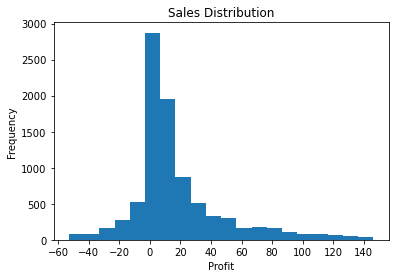

In [2]:
q_low = df["Profit"].quantile(0.05)
q_hi  = df["Profit"].quantile(0.94)
df = df[(df["Profit"] < q_hi) & (df["Profit"] > q_low)]

df_profit= df['Profit']
df_profit.hist(bins=20,grid=False)
plt.title('Sales Distribution')
plt.xlabel('Profit',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.locator_params(axis='x', nbins=20)
# plt.show()
plt.savefig('profit_histogram.png')

<b>Analyzing the quantitative attributes</b>, sales is positively correlated to profit; discounts are negatively correlated to profit, which makes sense in that the amount of discounts you give a customer will deter profit.

In [3]:
corr_matrix = df.corr()
corr_matrix["Profit"].sort_values(ascending=False)

Profit         1.000000
Sales          0.489031
Quantity       0.209080
Order Year    -0.005553
Postal Code   -0.018486
Discount      -0.372591
Name: Profit, dtype: float64

Looking closely at the correlation between sales & profit, one can see a STEEP trend, but there's a lot of data causing a fanning affect. There are a few outliers that dip under the main trend, but for the mose part there's a perceptible upward trend in the data.

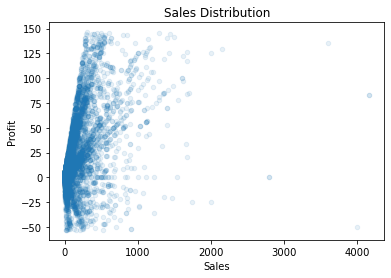

In [4]:
hist = df.plot(kind="scatter",x="Sales",y="Profit",alpha=0.1,title ="Sales Distribution")

hist.figure.savefig('sales_to_profit_histogram.png')

<b>Analyzing the qualitative attributes</b>, we understand that some of our features are 'hierarchical' in nature, meaning the attributes assigned to an observation can be grouped into categories already assigned to the observation. For example, we can remove the product_id and customer_id because of it's <b>collinearity</b> with product and customer categories. Since Order id and rowid is unique per order, we can drop that as well. We can remove the 'Product Sub-category' as this is colinear to Product Category too.

Another element we will remove from this model is lower level location attributes, such as city, state, and postal code; they too have a <b>colinear</b> relationship with region.

Let's explore the features using violin plots


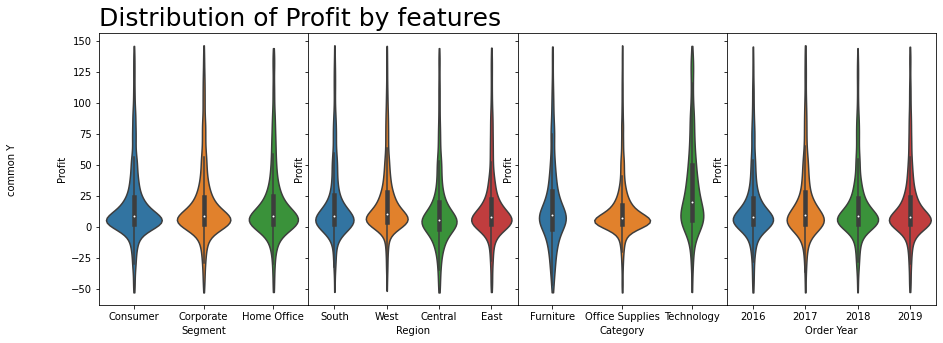

In [5]:
cleaned_df = df.drop(['Product ID','Sub-Category','Order ID','City','State','Postal Code','Customer ID'], axis = 1)
fig, axes = plt.subplots(1, 4,figsize=(15,5),sharey='row')
fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
plt.subplots_adjust(wspace=0)
sns.violinplot(df["Segment"],df["Profit"], ax=axes[0], cut=0) #ztest
sns.violinplot(df["Region"],df["Profit"], ax=axes[1], cut=0) #ztest
sns.violinplot(df["Category"],df["Profit"], ax=axes[2], cut=0) #ztest
sns.violinplot(df["Order Year"],df["Profit"], ax=axes[3], cut=0) #ztest
plt.suptitle('Distribution of Profit by features', ha = 'left',fontsize=25,x=0.125,y=.9,va='baseline')

plt.savefig('profit_distributiion_violins.png')

#Code body for violin plots respectfully derived from this project: https://github.com/a-woodbury/A-House-with-a-View

<i><b>Violin plots</b></i> are great when you want to review numeric data (Profit) and its distribution among groups of data; it also shows the interquartile range of the profit data within each group & sets them side by side for easy comparisons. I love how easily you can see <b>density</b> or frequency of the data for each group.

For the most part, the means & interquartile ranges for profit are similar for all categories in Segment, Region, and Order Year. The shapes of the distributions between each category in Segment, Region, and Order are also similar, indicating that there are is a small frequency of really large values making the smoothed distributions (i.e. the shape of the violins) look really stretched.

The category feature contains some interesting insights: It looks like Office Supplies have really low profits for the most part (hence the fat shape of the violin); furniture & technology are very thin and give the indication that they have higher price points than that of office supplies. This make sense given that furniture & technology tend to be more expensive.

Since the product category plays a huge factor in the behavior of the data, we will consider this when we create dummy variables

In [6]:
#Added Dummy Variables to NoofStories & DwellingType
Segments = pd.get_dummies(cleaned_df['Segment'])
Regions = pd.get_dummies(cleaned_df['Region'])
Categories = pd.get_dummies(cleaned_df['Category'])
OrderYears = pd.get_dummies(cleaned_df['Order Year'])

#Joined to dummy variables & original continuous variables to new dataframe. Drop data we do not need in the model
processed_results = pd.concat([cleaned_df, Segments ,Regions,Categories["Office Supplies"],OrderYears], axis=1, join='inner')
processed_results = processed_results.drop(['Region','Segment','Category','Order Year'], axis = 1)


## Modeling and Performance





<b>Preprocessing Quantiative Variables</b>

Now that we have the qualitative & quantitative attributes selected, we should look at how to standardize the quatitative attributes. Attributes like 'Sales' and 'Order Year' could become more influential than 'Quantity' and 'Discount' in our model given the larger size observations. 

Let's use Sci-Kit Learn's Standard Scaler to ensure that certain variables do not have more weight in our model

In [7]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
processed_results[['Sales','Quantity','Discount','Profit_Processed']]= scaler.fit_transform(processed_results[['Sales','Quantity','Discount','Profit']])


<b>Create a Test Set</b>

Before we continue further, let's isolate our target variable (Profit) from our features. After that, let's break out our dataset into a training & test set. Given that the data is close to 100k records, I will use 10% of the data to test, giving me ~90k to train and ~10k to test my model.

I will use Scikit-Learn to break out data into train & test; since I might need to rerun my code a few times, I'm using seeding to ensure that results in my test & train set do not overlap

In [8]:
from sklearn.model_selection import train_test_split

target = processed_results[['Profit','Profit_Processed']]
features = processed_results.drop(['Profit','Profit_Processed'], axis = 1)
data_train,data_test,target_train,target_test = train_test_split(features,target['Profit'],test_size=0.1,random_state=42)

<b>Select and Train Linear Regression Model</b>

Now that we have our explored, preprocessed, and split our dataset into a training & testing set, let's first train a linear regression model.

In [9]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(data_train,target_train)
print("R^2 Score: ",lin_reg.score(data_test, target_test))

R^2 Score:  0.42126103601630394


Yikes, not a great R^2 score; we're looking to get closer to 1. Let's try tweaking out model by adding polynomial features and Random Forest Regression instead

<b>Adding Polynomial Features</b>

Let see if by adding polynomial features with 2 degrees of freedom will make the R^Squared score better

In [10]:
from sklearn.preprocessing import PolynomialFeatures

quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(features)

data_train,data_test,target_train,target_test = train_test_split(x_quad,target['Profit'],test_size=0.1,random_state=42)

plr = LinearRegression().fit(data_train,target_train)

Y_train_pred = plr.predict(data_train)
Y_test_pred = plr.predict(data_test)

print("R^2 Score: ",plr.score(data_test,target_test))

R^2 Score:  0.4727783991275235


<b>Random Forest Regression</b>

By incorporating polynomial features into our model, it gets a little bit better R^2 but not by much. Let's try RandomForestRegressor instead


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

forest = RandomForestRegressor(n_estimators = 100, criterion = 'mse', random_state = 1, n_jobs = -1)
forest.fit(data_train,target_train)
forest_train_pred = forest.predict(data_train)
forest_test_pred = forest.predict(data_test)

print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(target_train,forest_train_pred),
mean_squared_error(target_test,forest_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(target_train,forest_train_pred),
r2_score(target_test,forest_test_pred)))

MSE train data: 42.538, MSE test data: 344.352
R2 train data: 0.954, R2 test data: 0.686


Wow! Much better! Looks like Random Forest does a wayyy better job determining our model than linear or logistic regression.

## Results

<b>Plotting the Results</b>
Since Random Forest performed the best out of the 3 models, let's show how our training set compares to our testing set



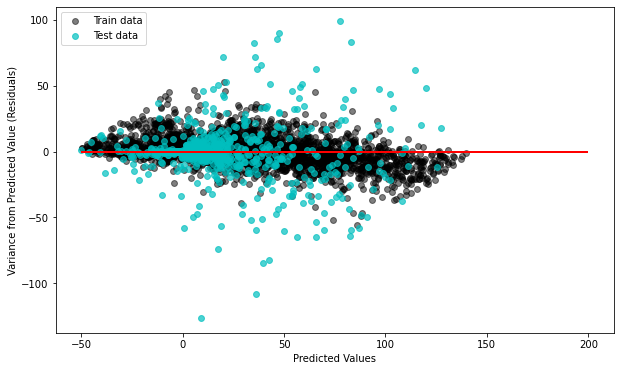

In [12]:
plt.figure(figsize=(10,6))

plt.scatter(forest_train_pred,forest_train_pred - target_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(forest_test_pred,forest_test_pred - target_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted Values')
plt.ylabel('Variance from Predicted Value (Residuals)')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -50, xmax = 200, lw = 2, color = 'red')
plt.savefig('test_train_scatter.png')

For the most part, our model did a pretty good job predicting profit! There's still some outliers that didn't quite make the cut BUT for the most part, our random forest model did a pretty good job predicting profit.


Here's the primary reason I think caused a problem with the model (inspired by An Introduction to Statistical
Learning): 

<b>Non-Linearity of the data!</b> As much as we wanted to infer a linear relationship between profit and the features, it really doesn't look like that's true. The above scatter plot above depicting the residuals shows this.

## Summary of Results & Observations

While Random Forest did a relatively good job at predicting Profit, here's what I would say to my stakeholders about the model:

<ol>
  <li><b>The Model Like Cheap Products, Especially Office Supplies</b> In a perfect world, we would have a great representation of all products that Super Store sells. Realistically with this data, a ton of orders were really low in price and therefore profit. The model is great at predicting cheaper products sold by Superstore</li>
  <li><b>How about overseas sales? </b> Assuming that SalesSuperstore has business overseas (I mean they ARE a superstore affter all), I'd like to incorporate data for overseas sales to get a true picture. Different countries may have different preferences and may buy more furniture/tech than office supplies.</li>
    <li><b>More historical years please! </b>If we have more than the past 4 years' worth of data, we could provide an even better prediction of future profits.</li>
</ol>